# Branch and Bound Node Implementation:

#### Imports:

In [3]:
import numpy as np
import cvxpy as cp
import math
import graphviz
from IPython.display import Image, display

In [9]:
class BranchAndBoundIntegers:
    best_solution = None
    best_variables = None
    variable_names = {}
    

    def __init__(self, objective, constraints) -> None:
        self.type = "max" if isinstance(objective, cp.Maximize) else "min"
        self.objective = objective
        self.constraints = constraints
        self.problem = cp.Problem(objective, constraints)
        self.solution = self.problem.solve()
        self.variable_values = {var.name(): var.value for var in self.objective.variables()}
        self.nexts = []
    
    def find_integer_optimal_solution(self, is_root=True):
        if is_root:
            self._initialize_statics()
            
        # Find variable that is not integer
        next_x, x_val = self._get_first_non_integer_variable()

        # If all variables are integers - done.
        if next_x is None:
            self._update_best_solution_if_needed()
            return BranchAndBoundIntegers.best_solution, BranchAndBoundIntegers.best_variables
                
        # If current solution is no better than current best solution found, there is no need to keep this branching.
        if not self._has_better_solution():
            return BranchAndBoundIntegers.best_solution, BranchAndBoundIntegers.best_variables

        # Keep branching
        self._branch_with_new_bound([next_x == math.floor(x_val)])
        self._branch_with_new_bound([next_x == math.ceil(x_val)])
        #############################################################################################################################
        # NOTE: Basically <= \ >= should be used here                                                                               #
        # However, it is enough in our examplse, as we looking for integers that mostly close to the optimal solution.              #
        # Therefore, branching deeper to +-1 will surely lead to a worse solution.                                                  #
        #############################################################################################################################

        return BranchAndBoundIntegers.best_solution, BranchAndBoundIntegers.best_variables
    
    def _set_as_best(self):
        BranchAndBoundIntegers.best_solution = self.solution
        BranchAndBoundIntegers.best_variables = self.variable_values

    def _has_better_solution(self):
        if BranchAndBoundIntegers.best_solution is None:
            return True
        elif self.type == "max" and BranchAndBoundIntegers.best_solution < self.solution:
            return True
        elif self.type == "min" and BranchAndBoundIntegers.best_solution > self.solution:
            return True
        
        return False

    def _update_best_solution_if_needed(self):
        if BranchAndBoundIntegers.best_solution is None or self._has_better_solution():
            self._set_as_best()

    def _get_first_non_integer_variable(self):
        for name, value in self.variable_values.items():
            if value != None and abs(value - np.round(value)) >= 1e-6:
                for var in self.objective.variables():
                    if var.name() == name:
                        return var, value
        return None, None

    def _branch_with_new_bound(self, new_bound):        
        subproblem = BranchAndBoundIntegers(self.objective, self.constraints + new_bound)
        self.nexts.append(subproblem)
        subproblem.find_integer_optimal_solution(is_root=False)

    def _initialize_statics(self):
        BranchAndBoundIntegers.best_solution = None
        BranchAndBoundIntegers.best_variables = None
        i = 1
        for var in self.objective.variables():
            BranchAndBoundIntegers.variable_names[var.name()] = f'x{i}'
            i += 1

    def _get_xs_values(self):
        values_str = ""
        i = 0
        for name, value in self.variable_values.items():
            if value is not None and name in BranchAndBoundIntegers.variable_names:
                if i != 0 and i % 3 == 0:
                    values_str += '<BR/>'
                formatted_value = f"{value:.3f}".rstrip('0').rstrip('.')
                values_str += f"{BranchAndBoundIntegers.variable_names[name]} = {formatted_value}"
                if i % 3 < 2:
                    values_str += ', '
                i += 1
        return values_str
    
    def _add_node_to_graph(self, graph, node, label):
        node_id = str(id(node))
        formatted_solution = f"{node.solution:.3f}".rstrip('0').rstrip('.')
    
        # Modified line: Use Graphviz table to separate sections
        node_label = f'<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0"><TR><TD><b>Z = {formatted_solution}</b></TD></TR><TR><TD>{node._get_xs_values()}</TD></TR></TABLE>>'  # Modified line
    
        if node.solution == BranchAndBoundIntegers.best_solution:
            graph.node(node_id, label=node_label, shape='plaintext', color='red', style='filled', fillcolor='white', penwidth='2')
        else:
            graph.node(node_id, label=node_label, shape='plaintext')
    
        for next_node in node.nexts:
            next_node_id = str(id(next_node))
            last_constraint = next_node.constraints[-1]
            edge_label = f'{last_constraint}'.replace("==","=")
            for var_expr, var_name in BranchAndBoundIntegers.variable_names.items():
                edge_label = edge_label.replace(var_expr, var_name)
            graph.edge(node_id, next_node_id, label=edge_label)
            self._add_node_to_graph(graph, next_node, edge_label)
        
    def display_tree(self):
        graph = graphviz.Digraph()
        self._add_node_to_graph(graph, self, "Root")
        graph.render('branch_and_bound_tree', format='png')
        display(Image('branch_and_bound_tree.png'))

# Usage Over Our First Example

26.999999999285848
{'var32': array(3.), 'var33': array(2.)}


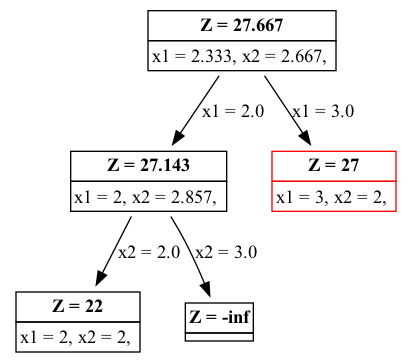

In [5]:
x = cp.Variable()
y = cp.Variable()

# Define the objective function
objective = cp.Maximize(5 * x + 6 * y)

# Define the constraints
constraints = [2 * x + y <= 20,
               4 * x + 7 * y <= 28,
               x + y <= 5,
               x >= 0,
               y >= 0]

# Create a BranchAndBound node
bnb = BranchAndBoundIntegers(objective, constraints)
best_solution, best_variables = bnb.find_integer_optimal_solution()

print(best_solution)
print(best_variables)

bnb.display_tree()

# Knapsack Problem
- The bag has capacity of size $W$
- There are totaly $n \in \N$ items to select
- Each item $i$ cost $0 \leq w_i \leq W$
- Each item $i$ has $p_i\in\R$ value

We define $x_i\in{0,1}$ such that 0 represnet the item is not selected and 1 if it do.
<br><br>
We want to maximize $Z=\sum_{i=1}^n{x_i\cdot p_i}$ such that:
- $\sum_{i=1}^n{x_i\cdot w_i}\leq W$

In [11]:
def run_knapsack_example(W, items):
    xs = [cp.Variable() for _ in range(len(items))]
    objective = cp.Maximize(sum(item["value"] * xs[i] for i, item in enumerate(items)))

    total_cost = sum(item["cost"] * xs[i] for i, item in enumerate(items))
    constraints = [xi <= 1 for xi in xs] + [xi >= 0 for xi in xs] + [total_cost<=W]

    bnb = BranchAndBoundIntegers(objective, constraints)
    best_solution, best_variables = bnb.find_integer_optimal_solution()

    print(best_solution)
    print(best_variables)

    bnb.display_tree()

## Knapsack Example 1:

248.99999998908234
{'var1539': array(1.35997711e-15), 'var1540': array(1.), 'var1541': array(1.), 'var1542': array(1.), 'var1543': array(1.), 'var1544': array(1.54734698e-15)}


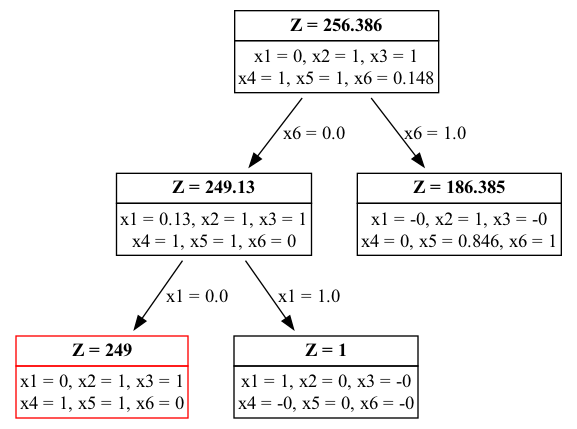

In [12]:
W = 100
items = [ {"cost": 100, "value": 1},  
         {"cost": 1, "value": 100},  
         {"cost": 50, "value": 50}, 
         {"cost": 23, "value": 56},  
         {"cost": 13, "value": 43},  
         {"cost": 88, "value": 50}]

run_knapsack_example(W,items)

## Knapsack Example 2:

248.9999999107773
{'var2146': array(6.10140071e-15), 'var2147': array(1.), 'var2148': array(1.18434952e-14), 'var2149': array(1.), 'var2150': array(1.), 'var2151': array(8.60428987e-15), 'var2152': array(1.), 'var2153': array(1.), 'var2154': array(6.87199886e-15)}


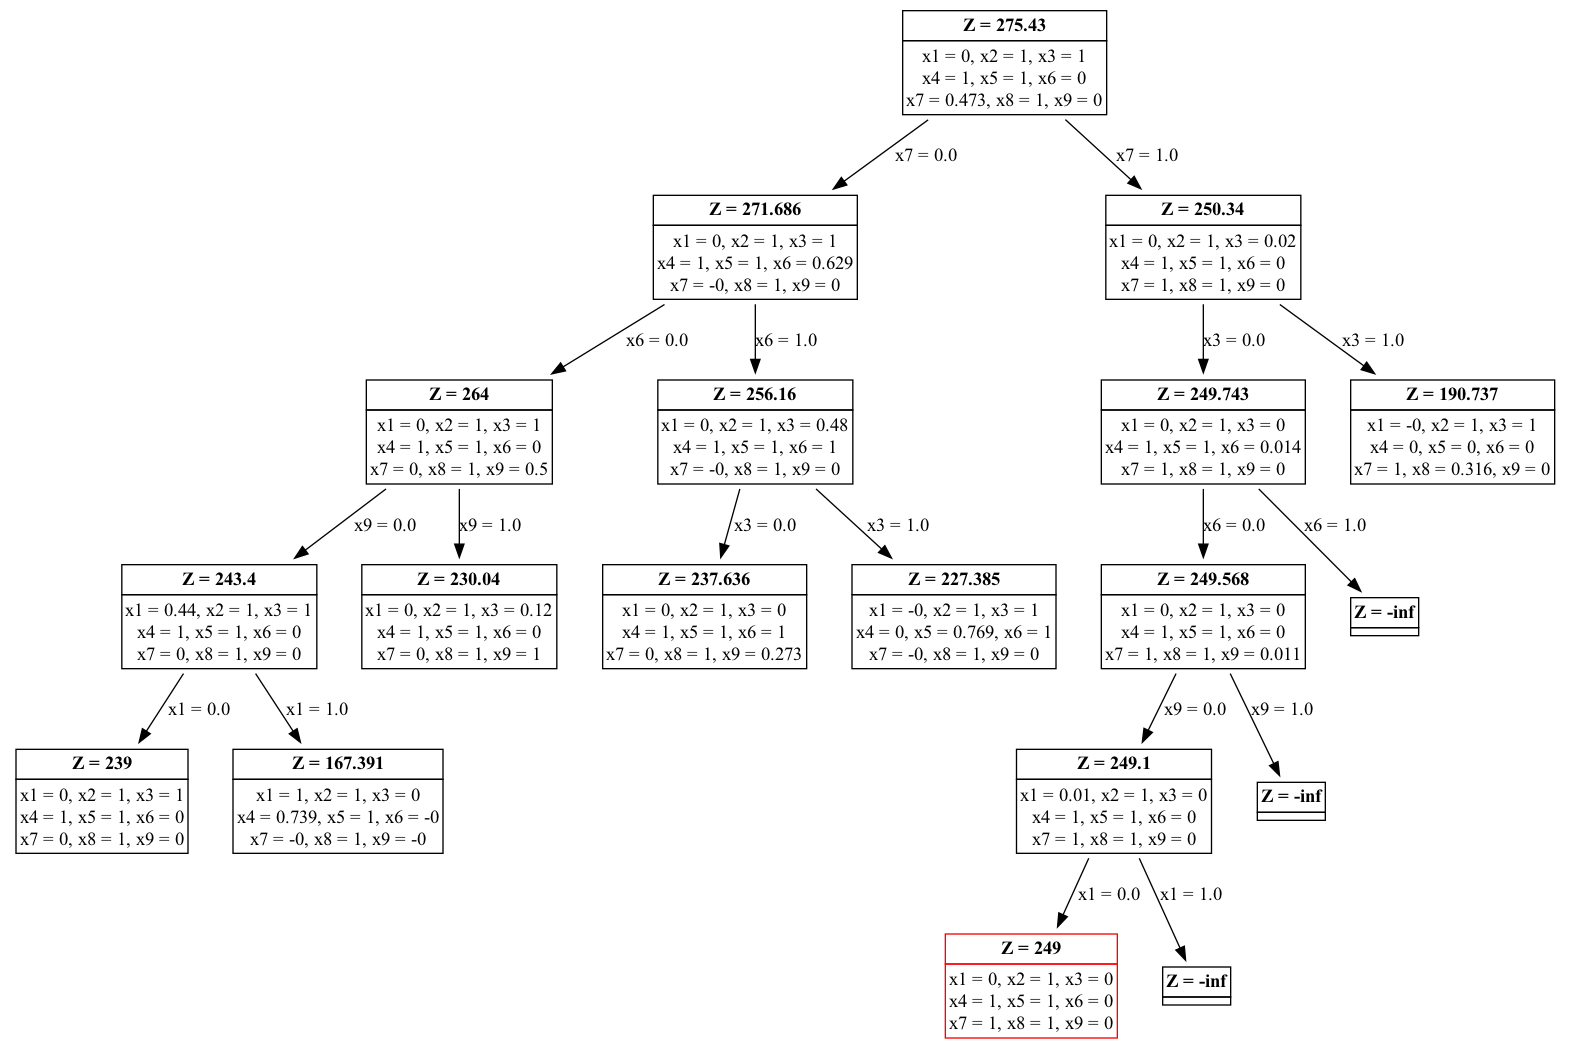

In [13]:
W = 150
items = [ {"cost": 100, "value": 10},  
         {"cost": 1, "value": 30},  
         {"cost": 50, "value": 67}, 
         {"cost": 23, "value": 56},  
         {"cost": 13, "value": 33},  
         {"cost": 70, "value": 52}, 
         {"cost": 93, "value": 77},  
         {"cost": 19, "value": 53},
         {"cost": 88, "value": 50}]

run_knapsack_example(W,items)